# Data Cleaning and Preprocessing

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlflow
from mlflow.models import infer_signature

# Tracking URL für den MLFlow Server setzen
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# Rohdaten importieren
excel_file_path = '2023_eim.xlsx'
# alle Tabellenblätter in ein Dictionary einlesen
all_sheets_dict = pd.read_excel(excel_file_path, sheet_name=None)

# leere Liste erstellen um die einzelnen DataFrames zu speichern
all_sheets_list = []

# Schleife über alle DataFrames in all_sheets_dict und diese in die Liste all_sheets_list einfügen
for sheet_name, sheet_df in all_sheets_dict.items():
    # Spalte 'Jahr' aus dem Sheet-Namen erstellen
    sheet_df['Jahr'] = sheet_name
    all_sheets_list.append(sheet_df)

# Zusammenführen der DataFrames in all_sheets_list zu einem DataFrame
combined_df = pd.concat(all_sheets_list, ignore_index=True)

# Speichern des DataFrames in eine Excel-Datei
combined_df.to_excel('2023_eim_combined.xlsx', index=False)

# Erstellen eines neuen DataFrames mit der Anzahl der einzigartigen Kunden und der Summe der fakturierbaren Tage, gruppiert nach 'Mitarbeiter' und 'Jahr'
grouped_df = combined_df.groupby(['Mitarbeiter', 'Jahr']).agg(
    num_customers=pd.NamedAgg(column='Anforderer', aggfunc='nunique'),
    sum_tage=pd.NamedAgg(column='Tage', aggfunc='sum')
).reset_index()

# Speichern des gruppierten DataFrames in eine Excel-Datei
grouped_df.to_excel('2023_eim_grouped.xlsx', index=False)

Die gruppierten Daten dienen als Basis für die weitere Aufbereitung der Daten, zu einer Excel Datei mit diversen Input Features.
Die Daten im zuvor erstellten DataFrame werden manuell angereichert. 
Hierzu zählen vor allen Dingen persönliche Daten, aber auch Informationen aus dem Vertriebsbereich.
- ist der Mitarbeiter in der Bestandskundenbetreuung tätig?
- Welches Skill-Level hat der Mitarbeiter in seinem Tätigkeitsgebiet?
- Alter des Mitarbeiters
- Berufserfahrung des Mitarbeiters
- Wie viele Fehltage sind im Jahr zu verzeichnen?
- Arbeitet der Mitarbeiter in Vollzeit oder Teilzeit?
- Wie viele Beratungstage sind für das kommende Jahr bereits fest eingeplant, durch vorhandene Aufträge? Wie schätzt der Teamleiter die mögliche Zielerreichung persönlich für den Mitarbeiter (konservativ aufgrund des Auftragsbestands) ein?



In [119]:
# importiere die Input Features aus einer Excel-Datei   
input_file_path = 'input_features.xlsx'

input_df = pd.read_excel(input_file_path)
# Anreicherung der Daten um Informationen zu den Arbeitstagen pro Jahr
arbeitstage = {2017: 247, 2018: 249, 2019: 249, 2020: 253, 2021: 253, 2022: 250, 2023: 248}
# Wirtschaftswachstum in Deutschland in Prozent
bip_deutschland = {2017: 2.7, 2018: 1, 2019: 1.1, 2020: -3.8, 2021: 3.2, 2022: 1.8, 2023: -0.3}
# FIS Umsatz pro Mitarbeiter in Euro
fis_turnover_per_employee = {2017: 98658, 2018: 102865, 2019: 104651, 2020: 107317, 2021: 109112, 2022: 111318, 2023: 114443}

# Spalte 'Arbeitstage' zum DataFrame hinzufügen, basierend auf der Spalte 'Jahr'
input_df['Arbeitstage'] = input_df['Jahr'].map(arbeitstage)
# Spalte 'Wirtschaftswachstum' zum DataFrame hinzufügen, basierend auf der Spalte 'Jahr'
input_df['Wirtschaftswachstum'] = input_df['Jahr'].map(bip_deutschland)
# Spalte 'FIS Umsatz pro Mitarbeiter' zum DataFrame hinzufügen, basierend auf der Spalte 'Jahr'
input_df['FIS Umsatz pro Mitarbeiter'] = input_df['Jahr'].map(fis_turnover_per_employee)
# Spalte 'Workdays' zum DataFrame hinzufügen, basierend auf der Spalte 'Vollzeit' multipliziert mit 'Arbeitstage'
input_df['Workdays'] = input_df['Vollzeit'] * input_df['Arbeitstage']

Kalkuliere, welche Kunden aus einer Kategorie die Berater in jeweiligen Jahr betreut haben.
Es soll nach Höhe des Aufwands geclustert werden.
Hat ein Berater einen Kunden mit mehr als 80 Tagen, so soll dieser in die Kunden Kategorie A fallen.
Hat ein Berater einen Kunden mit mehr als 40 Tagen, so soll dieser in die Kunden Kategorie B fallen.
Hat ein Berater einen Kunden mit weniger als 40 Tagen, so soll dieser in die Kunden Kategorie C fallen.
Hat ein Berater nur Kunden mit weniger als 10 Tagen soll in die Kunden Kategorie D fallen.

Es soll damit später geprüft werden, ob eine Korrelation zu den erzielten Beratungstagen besteht, wenn ein Berater einen Kunden betreut, bei dem viele Beratungstage anfallen.

In [120]:
# basierend auf dem combined_df DataFrame, erstelle ein neues DataFrame mit den Kunden Kategorien A, B, C, D pro Name

# filtere zunächst das combined_df DataFrame, wähle den höchsten Wert von 'Tage' für jeden 'Mitarbeiter' und 'Jahr'
customers_filtered_highest_df = combined_df.loc[combined_df.groupby(['Mitarbeiter', 'Jahr'])['Tage'].idxmax()]
# Spalte 'Kategorie' zum DataFrame hinzufügen
customers_filtered_highest_df['Kunden Kategorie'] = ''
# weise Kategorie D zu, wenn der Berater nur Kunden mit weniger als 10 Tagen betreut hat
customers_filtered_highest_df.loc[customers_filtered_highest_df['Tage'] <= 10, 'Kunden Kategorie'] = 0
# weise Kategorie C zu, wenn der Berater Kunden mit weniger als 40 Tagen betreut hat
customers_filtered_highest_df.loc[customers_filtered_highest_df['Tage'] > 10, 'Kunden Kategorie'] = 1
# weise Kategorie B zu, wenn der Berater Kunden mit weniger als 80 Tagen betreut hat
customers_filtered_highest_df.loc[customers_filtered_highest_df['Tage'] > 40, 'Kunden Kategorie'] = 2
# weise Kategorie A zu, wenn der Berater Kunden mit mehr als 80 Tagen betreut hat
customers_filtered_highest_df.loc[customers_filtered_highest_df['Tage'] > 80, 'Kunden Kategorie'] = 3
# speichere das DataFrame in eine Excel-Datei
customers_filtered_highest_df.to_excel('customers_filtered_highest.xlsx', index=False)


In [121]:
# 'Jahr' zu int konvertieren in beiden DataFrames
input_df['Jahr'] = input_df['Jahr'].astype(int)
customers_filtered_highest_df['Jahr'] = customers_filtered_highest_df['Jahr'].astype(int)

# basierend auf 'Name' und 'Jahr', 'Kategorie' von customers_filtered_highest_df zu input_df hinzufügen
input_df = input_df.merge(customers_filtered_highest_df[['Mitarbeiter', 'Jahr', 'Kunden Kategorie']], left_on=['Name', 'Jahr'], right_on=['Mitarbeiter', 'Jahr'], how='left')

# lösche die Spalte 'Mitarbeiter' aus dem DataFrame wegen Datenschutz
# der Name des Mitarbeiters ist nicht wichtig für das Modell
input_df.drop(columns=['Mitarbeiter', 'Name'], inplace=True)

# 'Kunden Kategorie' zu int konvertieren
input_df['Kunden Kategorie'] = input_df['Kunden Kategorie'].astype(int)


In [122]:
# der vorliegende Datenframe wird auf Berater gefiltert, bei denen die notwendigen Input Features vorhanden sind.
# es genügt in diesem Fall auf die Spalte 'Alter' zu prüfen
input_df = input_df[input_df['Alter'].notna()]

# der gefilterte DataFrame wird in eine Excel-Datei gespeichert
input_df.to_excel('input_features_filtered.xlsx', index=False)

Der Aufbau der notwendigen Input Features ist abgeschlossen.
Im Weiteren folgt die Datenanalyse und das erstellen der Modelle.

# Datenanalyse

## Beschreibung der Input Features
<table>
<tr>
        <th>Spalte</th>
        <th>Beschreibung</th>
        <th>Feature Typ</th>
    </tr>
    <tr>
        <td>Alter</td>
        <td>Alter des Mitarbeiters in Jahren</td>
        <td>Numerical - Ratio</td>
    </tr>
    <tr>
        <td>Berufserfahrung</td>
        <td>Berufserfahrung des Mitarbeiters in Jahren</td>
        <td>Numerical - Ratio</td>
    </tr>
    <tr>
        <td>Anzahl Kunden</td>
        <td>Betreute Kunden im vorliegenden Jahr</td>
        <td>Numerical - Ratio</td>
    </tr>
    <tr>
        <td>Bestandskunden</td>
        <td>Ist der Mitarbeiter in der Bestandskundenbetreuung tätig (Supportbereich oder Neukundenprojekte)</td>
        <td>Categorical - Nominal</td>
    </tr>
    <tr>
        <td>Skill Level</td>
        <td>Welches Skill Level hat der Mitarbeiter in der Skill Matrix des Unternehmens</td>
        <td>Categorical - Ordinal</td>
    </tr>
    <tr>
        <td>Fehltage</td>
        <td>Anzahl der Fehltage im Jahr</td>
        <td>Numerical - Ratio</td>
    </tr>
    <tr>
        <td>Vollzeit</td>
        <td>Arbeitet der Mitarbeiter Vollzeit (=1) oder in Teilzeit (=jeweiliger Anteil zu 1)</td>
        <td>Numerical - Ratio</td>
    </tr>
    <tr>
        <td>Auftragsbestand</td>
        <td>Anzahl an Beratungstagen, die durch neue Aufträge im neuen Jahr verplant sind und die der Teamleiter dem Mitarbeiter als konservativ eingeschätztes Ziel zugewiesen hat.</td>
        <td>Numerical - Ratio</td>
    </tr>
    <tr>
        <td>Arbeitstage</td>
        <td>Anzahl der Arbeitstage im Jahr</td>
        <td>Numerical - Ratio</td>
    </tr>
    <tr>
        <td>Wirtschaftswachstum</td>
        <td>Wirtschaftswachstum in Deutschland</td>
        <td>Numerical - Ratio</td>
    </tr>
    <tr>
        <td>FIS Umsatz pro Mitarbeiter</td>
        <td>Höhe des Umsatzes pro Mitarbeiter in der Firmengruppe</td>
        <td>Numerical - Ratio</td>
    </tr>
    <tr>
        <td>Workdays</td>
        <td>Anzahl der Arbeitstage pro Mitarbeiter unter Berücksichtigung von Vollzeit oder Teilzeit</td>
        <td>Numerical - Ratio</td>
    </tr>
    <tr>
        <td>Kunden Kategorie</td>
        <td>Hat der Mitarbeiter A, B oder C-Kunden betreut?</td>
        <td>Categorical - Ordinal</td>
    </tr>
    <tr>
        <td>Fakturierbare Tage</td>
        <td>Anzahl der fakturierbaren Arbeitstage pro Mitarbeiter</td>
        <td>Target</td>
    </tr>
</table>

In [130]:
# Der DataFrame besteht aus numerischen und kategorischen Daten.
# Die einzelnen Features werden entsprechend zugeordnet, für die weitere Analyse und das Erstellen der Modelle.
numeric_features = ['Alter', 
                    'Anzahl Kunden', 
                    'Berufserfahrung', 
                    'FIS Umsatz pro Mitarbeiter', 
                    'Workdays', 
                    'Fehltage', 
                    'Wirtschaftswachstum',
                    'Arbeitstage',
                    'Auftragsbestand']
ordinal_features = ['Skill Level',
                    'Kunden Kategorie']
nominal_features = ['Bestandskunden']

Alter                         0.504499
Anzahl Kunden                -0.244389
Berufserfahrung               0.482362
FIS Umsatz pro Mitarbeiter    0.060326
Workdays                      0.079132
Fehltage                     -0.222794
Wirtschaftswachstum          -0.140110
Arbeitstage                  -0.011545
Auftragsbestand               0.918485
Bestandskunden               -0.579493
Skill Level                   0.662047
Kunden Kategorie              0.648923
dtype: float64


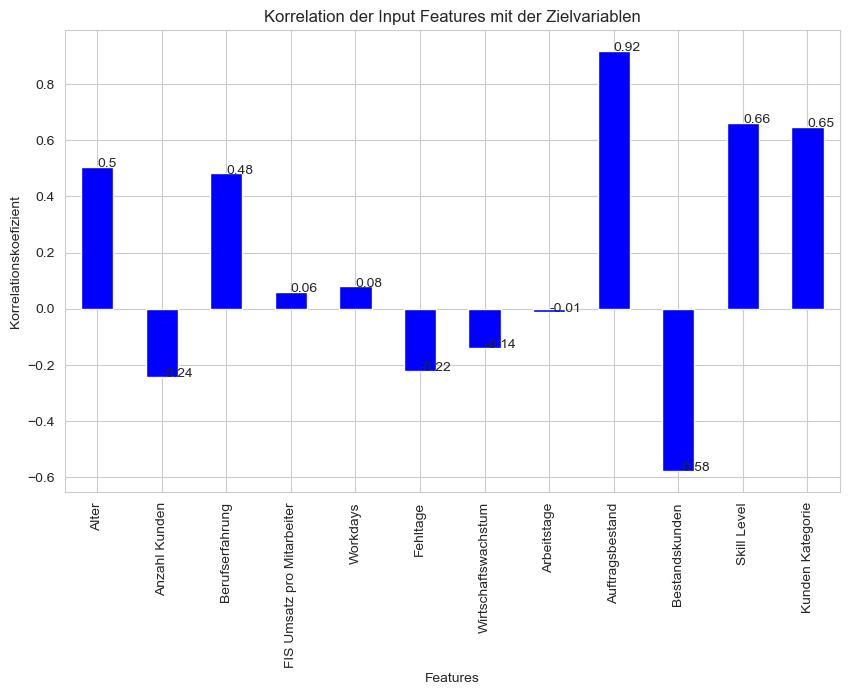

In [129]:
# Aufteilen der Daten in Input Features und Target Variable
X = input_df[numeric_features + categorical_features]
y = input_df['Fakturierbare Tage']

# Berechnung der Korrelation der einzelnen unabhängigen Variablen in X mit der Zielvariablen y
correlation = X.corrwith(y)
print(correlation)
# create a bar plot of the correlation of each independent variable with the target variable
plt.figure(figsize=(10, 6))
correlation.plot(kind='bar', color='blue')
# plot the values of each bar on the bar plot
for index, value in enumerate(correlation):
    plt.text(index, value, str(round(value, 2)))
plt.title('Korrelation der Input Features mit der Zielvariablen')
plt.xlabel('Features')
plt.ylabel('Korrelationskoefizient')
plt.show()

## Fokus auf relevante Features

Gemäß der ermittelten Korrelationen erfolgt eine Fokussierung auf folgende Features:
- Alter
- Anzahl Kunden
- Berufserfahrung
- Fehltage
- Auftragsbestand
- Bestandskunden
- Skill Level
- Kunden Kategorie

In [100]:
numeric_features_used = ['Alter', 
                    'Anzahl Kunden', 
                    'Berufserfahrung',  
                    'Fehltage',
                    'Auftragsbestand']
categorical_features_used = ['Bestandskunden', 
                        'Skill Level', 
                        'Kunden Kategorie']

# Update der X und y Variablen
X = input_df[numeric_features_used + categorical_features_used]
y = input_df['Fakturierbare Tage']

## Ermittlung von Multi-Kollinearität
Einige Features in X könnten miteinander korreliert sein. 

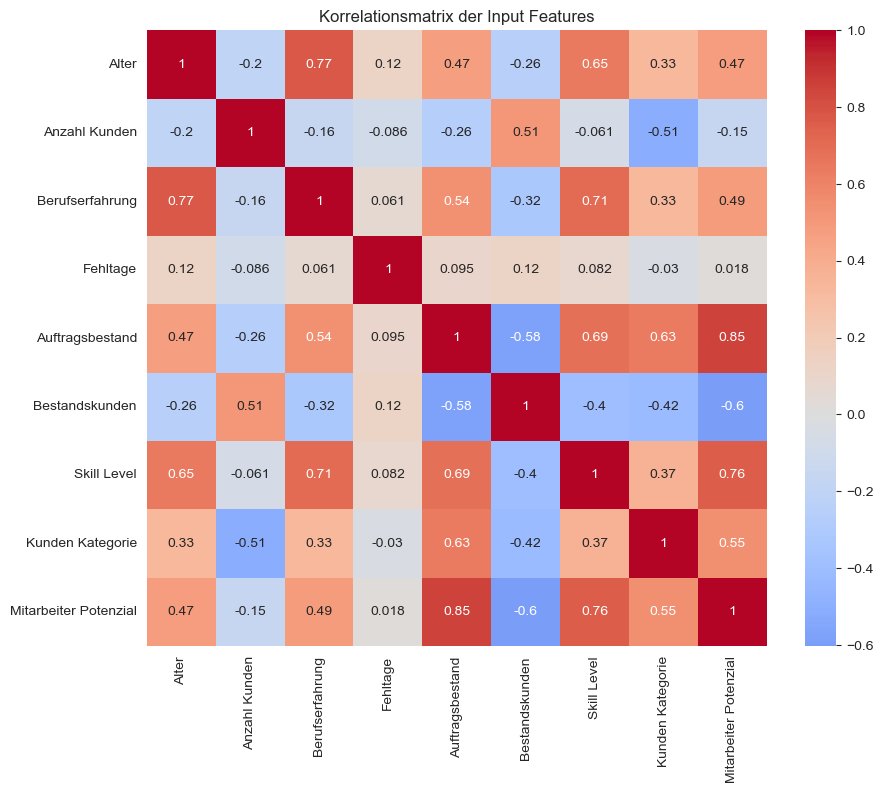

In [101]:
import seaborn as sns

# Erzeugen einer Korrelationsmatrix
correlation_matrix = X.corr()
plt.figure(figsize=(10, 8))

# Heatmap der Korrelationsmatrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

# Add title
plt.title('Korrelationsmatrix der Input Features')

# Show the plot
plt.show()

Berufserfahrung und Alter sind miteinander korreliert.
Wir verwenden im Folgenden das Alter als Input Feature und entfernen die Berufserfahrung.

In [103]:
numeric_features_used = ['Alter', 
                    'Anzahl Kunden',   
                    'Fehltage',
                    'Auftragsbestand']
categorical_features_used = ['Bestandskunden', 
                        'Skill Level', 
                        'Kunden Kategorie']

# Update der X und y Variablen
X = input_df[numeric_features_used + categorical_features_used]
y = input_df['Fakturierbare Tage']

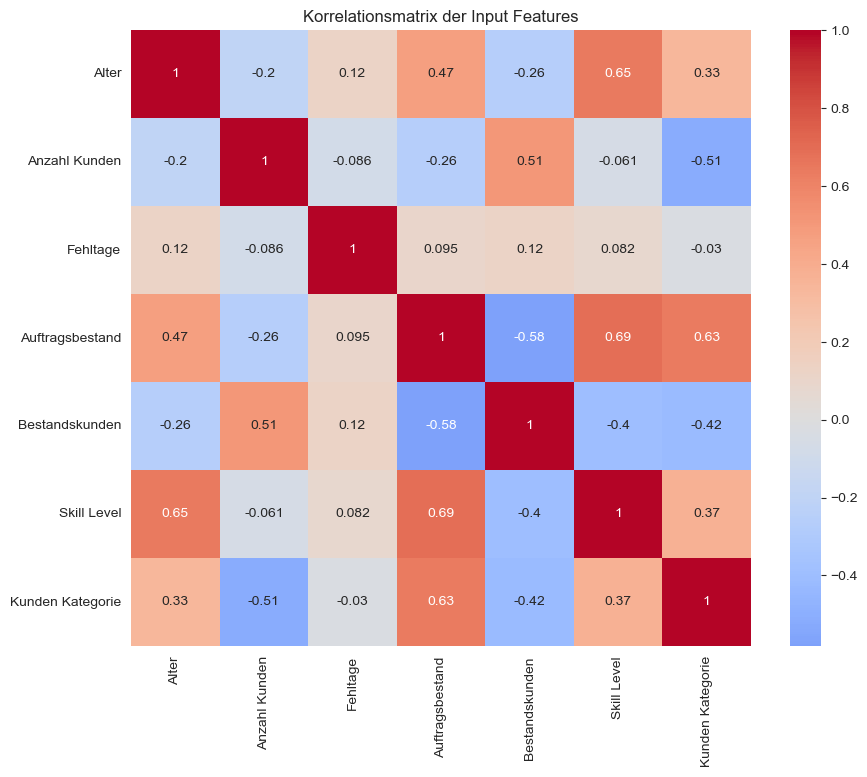

In [104]:
# Erzeugen einer Korrelationsmatrix
correlation_matrix = X.corr()
plt.figure(figsize=(10, 8))

# Heatmap der Korrelationsmatrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

# Add title
plt.title('Korrelationsmatrix der Input Features')

# Show the plot
plt.show()

Im paarweisen Vergleich der Input Features untereinander, sind nun keine Korrelationskoeffizienten mehr zu erkennen, die größer als 0.7 sind.

AttributeError: 'numpy.ndarray' object has no attribute 'scatter'

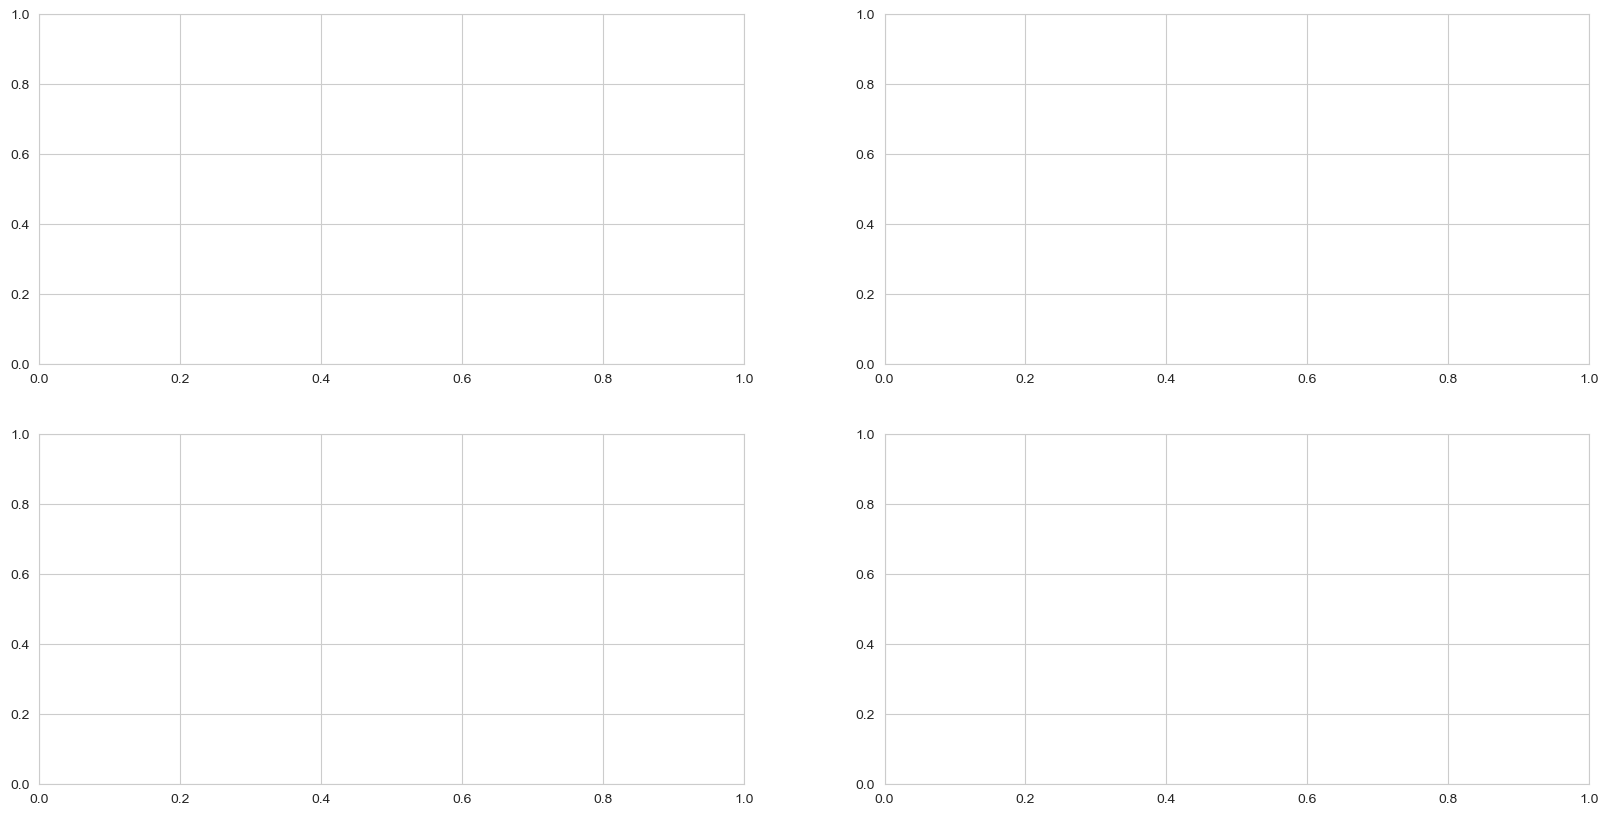

In [71]:
# show the correlation of the input features with the target variable in a scatter plot
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
# scatter plot for 'Alter' and 'Anzahl Kunden' with the target variable 'Tage'
axs[0].scatter(input_df['Alter'], input_df['Tage'], alpha=0.7)
axs[0].set_xlabel('Alter')
axs[0].set_ylabel('Tage')
axs[0].set_title('Alter vs. Tage')
axs[1].scatter(input_df['Anzahl Kunden'], input_df['Tage'], alpha=0.7)
axs[1].set_xlabel('Anzahl Kunden')
axs[1].set_ylabel('Tage')
axs[1].set_title('Anzahl Kunden vs. Tage')



plt.show()

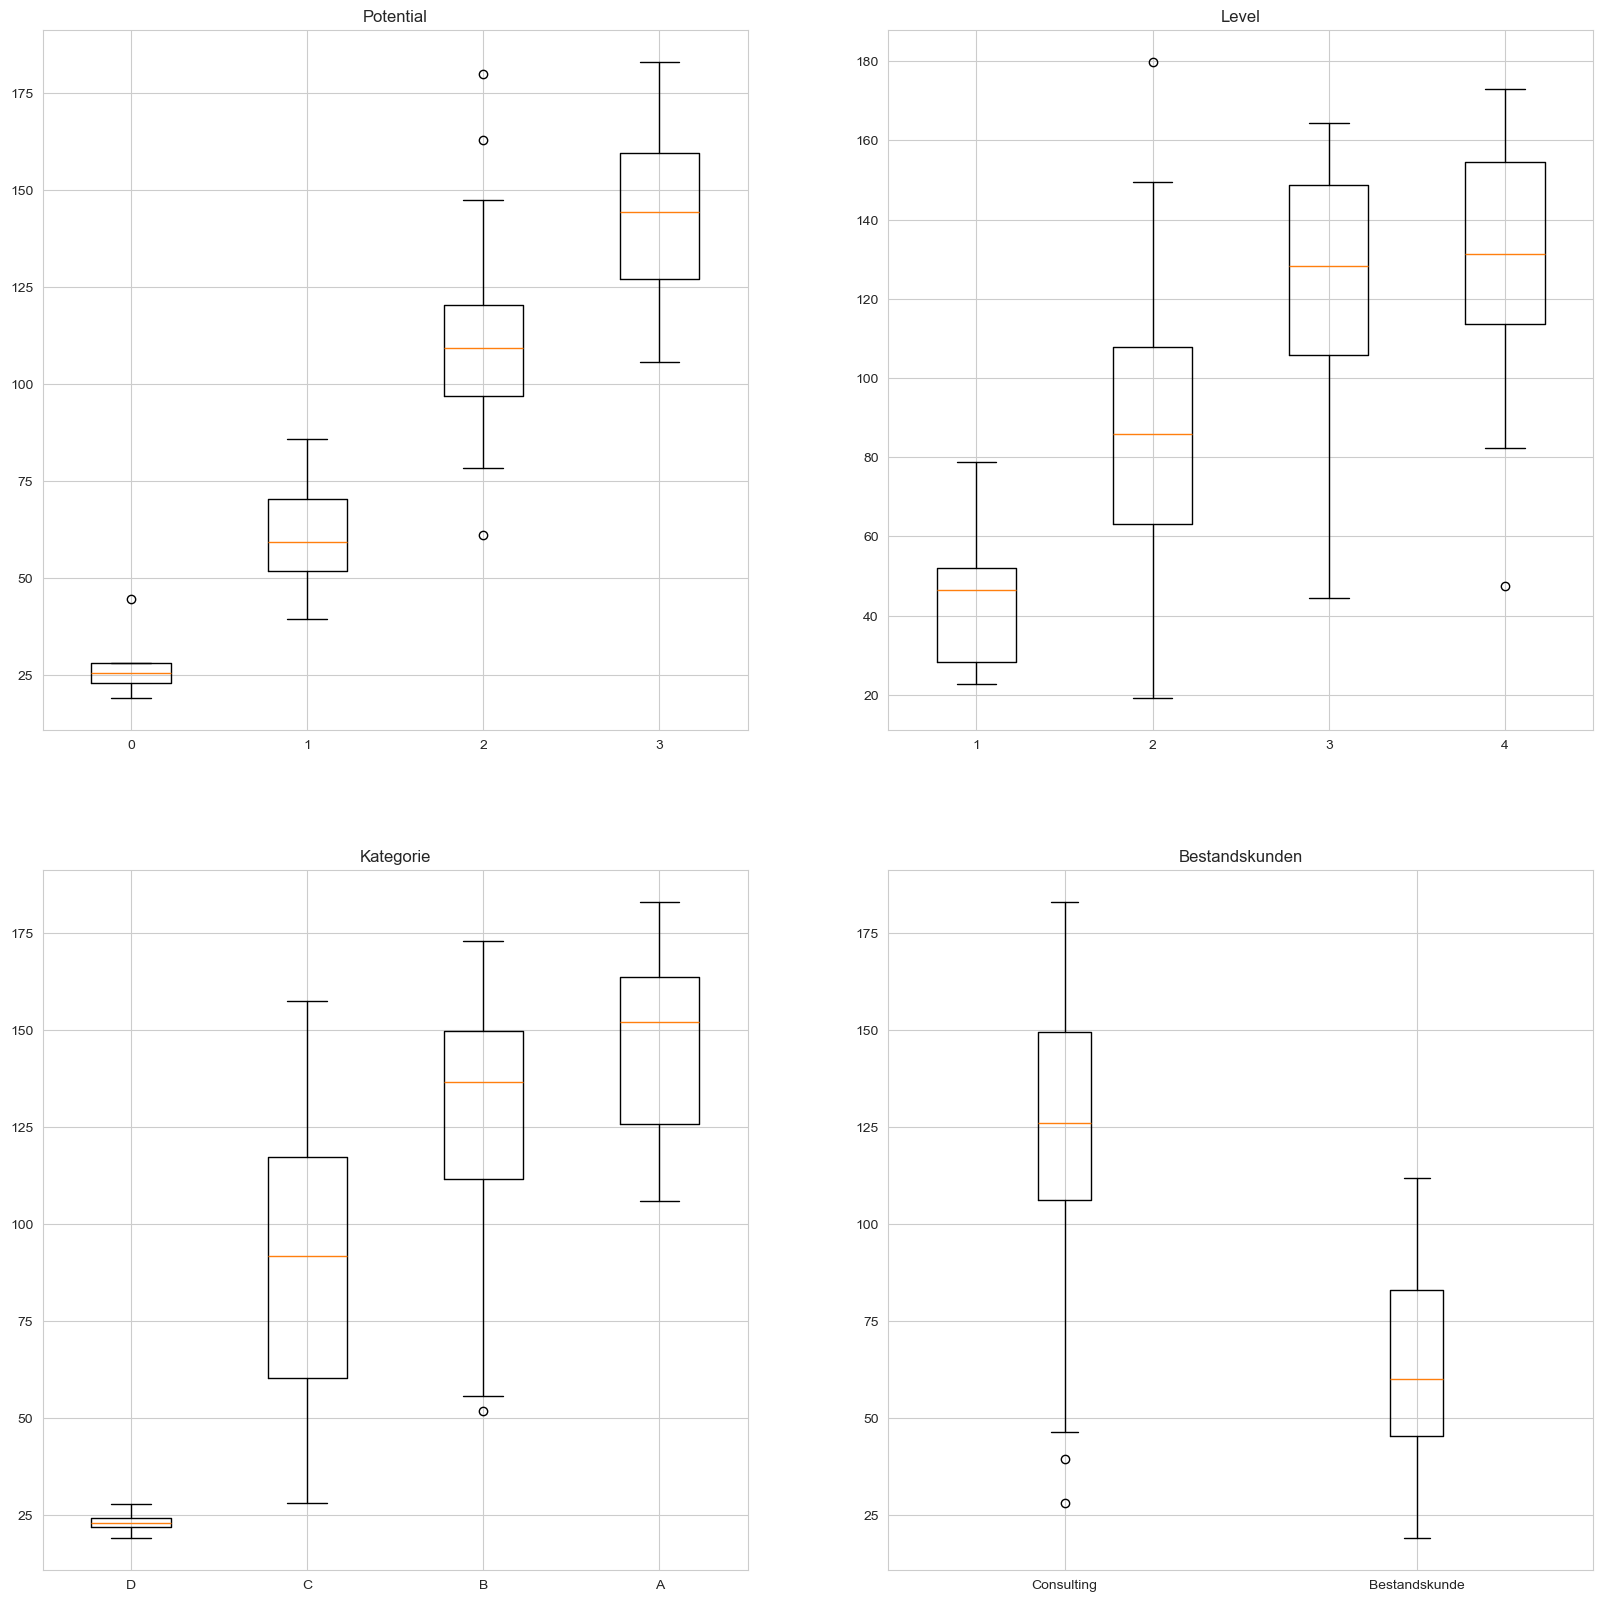

In [12]:
# create a boxplot of the input features with the target variable
# show the boxplot for 'Potential', 'Level', 'Kategorie' and 'Bestandskunden'
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
# boxplot for 'Potential' which is a categorical variable with 4 levels from 0 to 3
axs[0, 0].boxplot([input_df[input_df['Potential'] == 0]['Tage'], input_df[input_df['Potential'] == 1]['Tage'], input_df[input_df['Potential'] == 2]['Tage'], input_df[input_df['Potential'] == 3]['Tage']])
axs[0, 0].set_title('Potential')
axs[0, 0].set_xticklabels(['0', '1', '2', '3'])
# boxplot for 'Level' which is a categorical variable with 4 levels from 1 to 4
axs[0, 1].boxplot([input_df[input_df['Level'] == 1]['Tage'], input_df[input_df['Level'] == 2]['Tage'], input_df[input_df['Level'] == 3]['Tage'], input_df[input_df['Level'] == 4]['Tage']])
axs[0, 1].set_title('Level')
axs[0, 1].set_xticklabels(['1', '2', '3', '4'])
# boxplot for 'Kategorie' which is a categorical variable with 4 levels from D to A
axs[1, 0].boxplot([input_df[input_df['Kategorie'] == 0]['Tage'], input_df[input_df['Kategorie'] == 1]['Tage'], input_df[input_df['Kategorie'] == 2]['Tage'], input_df[input_df['Kategorie'] == 3]['Tage']])
axs[1, 0].set_title('Kategorie')
axs[1, 0].set_xticklabels(['D', 'C', 'B', 'A'])
axs[1, 1].boxplot([input_df[input_df['Bestandskunden'] == 0]['Tage'], input_df[input_df['Bestandskunden'] == 1]['Tage']])
axs[1, 1].set_title('Bestandskunden')
axs[1, 1].set_xticklabels(['Consulting', 'Bestandskunde'])

plt.show()


Zeige die Korellation der Input Features mit der Target Variable in je einem Scatter Plot.  

In [202]:
# create a pearson correlation test
from scipy.stats import pearsonr

# calculate the pearson correlation coefficient and the p-value for the correlation for every feature within X
for column in X:
    corr, p = pearsonr(X[column], y)
    print(f'Pearsons correlation coefficient between {column} and y: {corr}')
    print(f'p-value: {p}')
    if p > 0.05:
        print('The correlation is not significant')
    else:
        print('The correlation is significant')
    print('.......................................................')

Pearsons correlation coefficient between Alter and y: 0.5044992094813084
p-value: 1.9880609496311334e-09
The correlation is significant
.......................................................
Pearsons correlation coefficient between Anzahl Kunden and y: -0.244388896075226
p-value: 0.006020198305195097
The correlation is significant
.......................................................
Pearsons correlation coefficient between Bestandskunden and y: -0.57949295664304
p-value: 1.4365736618721084e-12
The correlation is significant
.......................................................
Pearsons correlation coefficient between Level and y: 0.6620474657622447
p-value: 4.2176117530974073e-17
The correlation is significant
.......................................................
Pearsons correlation coefficient between Kategorie and y: 0.64892270887354
p-value: 2.7500773723563656e-16
The correlation is significant
.......................................................
Pearsons correlation coe

# Linear Regression

## Aufbau eines Models mit den Input Features.
Jahr, Alter, Berufserfahrung, Anzahl Kunden, Bestandskunden
Die Target Variable ist die Variable Tage.

In [191]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline



preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Prepare the data for training the model
#X = input_df[['Alter', 'Berufserfahrung', 'Anzahl Kunden', 'Bestandskunden', 'FIS Umsatz pro Mitarbeiter', 'Workdays', 'Level', 'Kategorie']]
X = input_df[['Alter', 'Anzahl Kunden', 'Bestandskunden', 'Level', 'Kategorie', 'Potential']]
y = input_df['Tage']

# Split the data into training and cross validation data - 80% training, 20% cross validation
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=42)

# create pipeline
model = make_pipeline(preprocessor, LinearRegression())

# Train the model
model.fit(X_train, y_train)

# save the model to disk
import pickle
filename = 'bt_model.sav'
pickle.dump(model, open(filename, 'wb'))

# Evaluate the model with the cross validation data
y_pred_cv = model.predict(X_cv)
# Evaluate the model with the training data
y_pred_train = model.predict(X_train)

# Calculate metrics
score = model.score(X_cv, y_cv)

# Mean Squared Error with the cross validation data
mse_cv = mean_squared_error(y_cv, y_pred_cv)
# Mean Squared Error with the training data
mse_train = mean_squared_error(y_train, y_pred_train)
# Calculate the Mean Absolute Error with the cross validation data
mae_cv = np.mean(np.abs(y_cv - y_pred_cv))
# Calculate the Mean Absolute Error with the training data
mae_train = np.mean(np.abs(y_train - y_pred_train))
# Root Mean Squared Error with the cross validation data
rmse_cv = np.sqrt(mse_cv)
# Root Mean Squared Error with the training data
rmse_train = np.sqrt(mse_train)
print(f'Mean Squared Error CV: {mse_cv}')
print(f'Mean Absolute Error CV: {mae_cv}')
print(f'Root Mean Squared Error CV: {rmse_cv}')
print(f'Mean Squared Error Train: {mse_train}')
print(f'Mean Absolute Error Train: {mae_train}')
print(f'Root Mean Squared Error Train: {rmse_train}')

Mean Squared Error CV: 460.64982595875335
Mean Absolute Error CV: 17.685636449656553
Root Mean Squared Error CV: 21.462754388911815
Mean Squared Error Train: 244.84613244451785
Mean Absolute Error Train: 11.802765927948053
Root Mean Squared Error Train: 15.647559951778995


## Log the metrics to MLFlow

In [192]:
mlflow.set_experiment("Regression")

# Start an MLflow run
with mlflow.start_run():

    # Log the metrics
    mlflow.log_metric("Mean Squared Error CV", mse_cv)
    mlflow.log_metric("Mean Absolute Error CV", mae_cv)
    mlflow.log_metric("Root Mean Squared Error CV", rmse_cv)
    mlflow.log_metric("Mean Squared Error Train", mse_train)
    mlflow.log_metric("Mean Absolute Error Train", mae_train)
    mlflow.log_metric("Root Mean Squared Error Train", rmse_train)

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Logistic Regression", "Basic model with inputs of Alter, Anzahl Kunden, Bestandskunden, Level, Kategorie, Potential")

    # Infer the model signature
    signature = infer_signature(X_train, model.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="turnover_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="lr_model",
    )

/Users/sebastian/miniconda3/envs/pa_ds/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/Users/sebastian/miniconda3/envs/pa_ds/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in 

In [193]:
# print the y_cv and y_pred_cv values and compare them in a dataframe
output_df = pd.DataFrame({'y_cv': y_cv, 'y_pred_cv': y_pred_cv})
print(output_df)

# save the output_df to an excel file
output_df.to_excel('output.xlsx', index=False)

       y_cv   y_pred_cv
52   143.49  145.197392
129   58.27   55.959733
116  142.28  153.300791
178  147.35  143.273134
152   27.87   14.857374
193  133.17  115.827017
155   76.05   55.659623
239  155.09  145.641526
202  113.76  148.721081
18    78.71   36.483362
81    78.49  102.443951
232  143.47  150.187368
131   84.64   71.608890
205   28.19   58.431105
53   111.82  147.802969
179  150.03  143.731105
37    51.95   65.346723
210  162.85  122.222998
38    55.69   65.804694
230  119.76  142.341501
141  130.73  139.427035
180  148.85  138.849115
7    122.01  151.455071
73    98.43  104.094032
85    86.02  114.911074


In [194]:
# To get the output feature names
feature_names_transformed = model.named_steps['columntransformer'].get_feature_names_out()

print("Transformed Feature Names:")
print(feature_names_transformed)

X_transformed = preprocessor.transform(X_train)

# Create a DataFrame with the transformed data
transformed_df = pd.DataFrame(X_transformed, columns=feature_names_transformed)

# Export the DataFrame to a CSV file
transformed_df.to_csv('transformed_features.csv', index=False)

Transformed Feature Names:
['num__Alter' 'num__Anzahl Kunden' 'cat__Bestandskunden_0.0'
 'cat__Bestandskunden_1.0' 'cat__Level_1.0' 'cat__Level_2.0'
 'cat__Level_3.0' 'cat__Level_4.0' 'cat__Level_5.0' 'cat__Kategorie_0'
 'cat__Kategorie_1' 'cat__Kategorie_2' 'cat__Kategorie_3'
 'cat__Potential_0.0' 'cat__Potential_1.0' 'cat__Potential_2.0'
 'cat__Potential_3.0']


Try some regularization on the model to see if it improves the performance.

In [195]:
from sklearn.linear_model import Ridge

# Train the model with Ridge regularization
ridge_model = make_pipeline(preprocessor, Ridge(alpha=1))

ridge_model.fit(X_train, y_train)

# Evaluate the model with the cross validation data
y_pred_cv_ridge = ridge_model.predict(X_cv)
# Evaluate the model with the training data
y_pred_train_ridge = ridge_model.predict(X_train)

# Mean Squared Error with the cross validation data
mse_cv_ridge = mean_squared_error(y_cv, y_pred_cv_ridge)
# Mean Squared Error with the training data
mse_train_ridge = mean_squared_error(y_train, y_pred_train_ridge)
# Calculate the Mean Absolute Error with the cross validation data
mae_cv_ridge = np.mean(np.abs(y_cv - y_pred_cv_ridge))
# Calculate the Mean Absolute Error with the training data
mae_train_ridge = np.mean(np.abs(y_train - y_pred_train_ridge))
# Root Mean Squared Error with the cross validation data
rmse_cv_ridge = np.sqrt(mse_cv_ridge)
# Root Mean Squared Error with the training data
rmse_train_ridge = np.sqrt(mse_train_ridge)

#compare the results of the linear regression model with the ridge model
#only compare the root mean squared error
print(".......................................................")
print("Results from the linear regression model:")
print(f'Root Mean Squared Error CV: {rmse_cv}')
print(f'Root Mean Squared Error Train: {rmse_train}')
print(".......................................................")
print("Results from the ridge model:")
print(f'Root Mean Squared Error CV Ridge: {rmse_cv_ridge}')
print(f'Root Mean Squared Error Train Ridge: {rmse_train_ridge}')



.......................................................
Results from the linear regression model:
Root Mean Squared Error CV: 21.462754388911815
Root Mean Squared Error Train: 15.647559951778995
.......................................................
Results from the ridge model:
Root Mean Squared Error CV Ridge: 21.001336039089885
Root Mean Squared Error Train Ridge: 15.780665384276928


In [196]:
mlflow.set_experiment("Ridge Regression")

# Start an MLflow run
with mlflow.start_run():

    # Log the metrics
    mlflow.log_metric("Mean Squared Error CV Ridge", mse_cv_ridge)
    mlflow.log_metric("Mean Absolute Error CV Ridge", mae_cv_ridge)
    mlflow.log_metric("Root Mean Squared Error CV Ridge", rmse_cv_ridge)
    mlflow.log_metric("Mean Squared Error Train Ridge", mse_train_ridge)
    mlflow.log_metric("Mean Absolute Error Train Ridge", mae_train_ridge)
    mlflow.log_metric("Root Mean Squared Error Train Ridge", rmse_train_ridge)
    

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Ridge Regression", "Basic model with inputs of Alter, Anzahl Kunden, Bestandskunden, Level, Kategorie, Potential")

    # Infer the model signature
    signature = infer_signature(X_train, model.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="turnover_model",
        signature=signature,
        input_example=X_train,
        registered_model_name="lr_model",
    )

/Users/sebastian/miniconda3/envs/pa_ds/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/Users/sebastian/miniconda3/envs/pa_ds/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in 

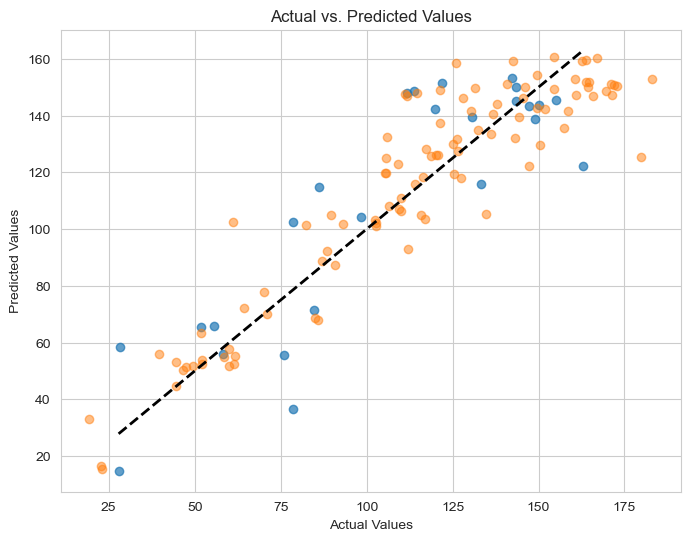

In [197]:
# visualize y_cv in blue and y_pred_cv in red in a scatter plot
# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(y_cv, y_pred_cv, alpha=0.7)
plt.scatter(y_train, y_pred_train, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.plot([y_cv.min(), y_cv.max()], [y_cv.min(), y_cv.max()], 'k--', lw=2)  # Diagonal line
plt.show()


# Neuronales Netz
Nachdem das Model mit Hilfe von Linearer Regression erstellt wurde, wird nun ein Model mit Hilfe eines neuronalen Netzes erstellt.

In [203]:
import tensorflow as tf
#from sklearn.preprocessing import StandardScaler
import keras
from keras import layers

#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Split the data into training and cross validation data - 80% training, 20% cross validation
X_train_nn, X_cv_nn, y_train_nn, y_cv_nn = train_test_split(X, y, test_size=0.2, random_state=42)

print(
    f"Using {len(X_train_nn)} records for training "
    f"and {len(X_cv_nn)} records for cross validation")
# print all data types of X_train_nn
print(X_train_nn.dtypes)

Using 100 records for training and 25 records for cross validation
Alter             float64
Anzahl Kunden       int64
Bestandskunden    float64
Level             float64
Kategorie           int64
Potential         float64
dtype: object


In [215]:
mlflow.set_experiment("Neural Network")
mlflow.tensorflow.autolog(registered_model_name="nn_model")

# build the neural network model
nn_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)
])

# compile the model
nn_model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_error', 'mean_squared_error'])

# train the model
# stop training when the validation loss metric has stopped decreasing for 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)

nn_model.fit(X_train_nn, y_train_nn, epochs=120, batch_size=1, validation_data=(X_cv_nn, y_cv_nn))


2024/03/06 16:24:09 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'fd9719d1afbd48de834644db21ef2d12', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2024/03/06 16:24:09 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.
2024/03/06 16:24:09 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'


Epoch 1/120
  1/100 [..............................] - ETA: 10s - loss: 127.8335 - mean_absolute_error: 127.8335 - mean_squared_error: 16341.4062WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0003s vs `on_train_batch_end` time: 0.0004s). Check your callbacks.


100/100 [==============================] - 0s 1ms/step - loss: 90.8539 - mean_absolute_error: 90.8539 - mean_squared_error: 10041.0186 - val_loss: 54.6742 - val_mean_absolute_error: 54.6742 - val_mean_squared_error: 4044.9919
Epoch 2/120
100/100 [==============================] - 0s 539us/step - loss: 40.8616 - mean_absolute_error: 40.8616 - mean_squared_error: 2389.1631 - val_loss: 28.0134 - val_mean_absolute_error: 28.0134 - val_mean_squared_error: 1101.5969
Epoch 3/120
100/100 [==============================] - 0s 533us/step - loss: 30.9905 - mean_absolute_error: 30.9905 - mean_squared_error: 1455.4546 - val_loss: 27.0031 - val_mean_absolute_error: 27.0031 - val_mean_squared_error: 1006.8502
Epoch 4/120
100/100 [==============================] - 0s 493us/step - loss: 29.9704 - mean_absolute_error: 29.9704 - mean_squared_error: 1350.8723 - val_loss: 25.5321 - val_mean_absolute_error: 25.5321 - val_mean_squared_error: 913.1116
Epoch 5/120
100/100 [==============================] - 0s 

2024/03/06 16:24:15 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2024/03/06 16:24:15 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/83/stm6j7fj5cv64zscjwszk3j40000gn/T/tmpkmxg3nxg/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/83/stm6j7fj5cv64zscjwszk3j40000gn/T/tmpkmxg3nxg/model/data/model/assets
2024/03/06 16:24:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/sebastian/miniconda3/envs/pa_ds/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils."
2024/03/06 16:24:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/sebastian/miniconda3/envs/pa_ds/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
Registered model 'nn_mo

In [ ]:
# evaluate the model with the cross validation data
print("Results for the cross validation data:")
print(nn_model.evaluate(X_cv_nn, y_cv_nn))

# evaluate the model with the training data
print("Results for the training data:")
print(nn_model.evaluate(X_train_nn, y_train_nn))

print(".......................................................")
print("Results from the linear regression model:")
print(f'Mean Squared Error CV: {mse_cv}')
print(f'Mean Absolute Error CV: {mae_cv}')
print(f'Root Mean Squared Error CV: {rmse_cv}')
print(f'Mean Squared Error Train: {mse_train}')
print(f'Mean Absolute Error Train: {mae_train}')
print(f'Root Mean Squared Error Train: {rmse_train}')

In [ ]:
# save the tensorflow model to disk
nn_model.save('tf_bt_model.keras')

# XGBoost - Decision Tree

In [ ]:
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from numpy import absolute

xg_model = xgb.XGBRegressor()

xg_model.fit(X_train, y_train)

xgb_scores = cross_val_score(xg_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
xgb_scores = absolute(xgb_scores)

xgb_predictions_cv = xg_model.predict(X_cv)
xgb_predictions_train = xg_model.predict(X_train)


# Mean Squared Error with the cross validation data
mse_cv_xgb = mean_squared_error(y_cv, xgb_predictions_cv)
# Mean Squared Error with the training data
mse_train_xgb = mean_squared_error(y_train, xgb_predictions_train)
# Calculate the Mean Absolute Error with the cross validation data
mae_cv_xgb = np.mean(np.abs(y_cv - xgb_predictions_cv))
# Calculate the Mean Absolute Error with the training data
mae_train_xgb = np.mean(np.abs(y_train - xgb_predictions_train))
# Root Mean Squared Error with the cross validation data
rmse_cv_xgb = np.sqrt(mse_cv_xgb)
# Root Mean Squared Error with the training data
rmse_train_xgb = np.sqrt(mse_train_xgb)

print(".......................................................")
print("Results from the decision tree xgbregressor:")
print(f'Mean Squared Error CV: {mse_cv_xgb}')
print(f'Mean Absolute Error CV: {mae_cv_xgb}')
print(f'Root Mean Squared Error CV: {rmse_cv_xgb}')
print(f'Mean Squared Error Train: {mse_train_xgb}')
print(f'Mean Absolute Error Train: {mae_train_xgb}')
print(f'Root Mean Squared Error Train: {rmse_train_xgb}')




# Try polynomial features

In [220]:
# Prepare the data for training the model
#X = input_df[['Alter', 'Berufserfahrung', 'Anzahl Kunden', 'Bestandskunden', 'FIS Umsatz pro Mitarbeiter', 'Workdays', 'Level', 'Kategorie']]
X = input_df[['Berufserfahrung', 'Anzahl Kunden', 'Potential', 'Level']]
y = input_df['Tage']

# Split the data into training and cross validation data - 80% training, 20% cross validation
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=42)
numeric_features = ['Berufserfahrung', 'Anzahl Kunden']
categorical_features = ['Potential', 'Level']
# preprocess the data and apply scaling
poly_preprocessor = ColumnTransformer(
    transformers=[
        ('poly', PolynomialFeatures(degree=3), numeric_features),
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])
# create pipeline
poly_model = make_pipeline(poly_preprocessor, LinearRegression())

# Train the model
poly_model.fit(X_train, y_train)
y_poly_pred_train = poly_model.predict(X_train)
y_poly_pred_cv = poly_model.predict(X_cv)

poly_rmse_train = np.sqrt(mean_squared_error(y_train, y_poly_pred_train))
poly_rmse = np.sqrt(mean_squared_error(y_cv, y_poly_pred_cv))

print(f'Root Mean Squared Error Train: {poly_rmse_train}')
print(f'Root Mean Squared Error CV: {poly_rmse}')


Root Mean Squared Error Train: 17.54857058894444
Root Mean Squared Error CV: 18.96814336196312
